## Overview of Dale's Transform

 1. Compute non-negative decoders from ```pre``` to ```post```, ```d_ampa``` and ```d_nmda```, that have corresponding synaptic filters h_ampa and h_nmda which have biologically-realistic time constants.
 
 2. These decoders compute a function ```f(x) = func_pos(stim)``` that is non-negative, allowing the non-negative least squares solver ```NnlsL2()``` to optimize effectively. The activity matrix is formed by stacking ```h_ampa.filt(spikes)``` and ```h_nmda.filt(spikes)```, allowing ```NnlsL2()``` to find decoders that account for the mixing of these two synapses. Note that ```func_pos()``` must be chosen to ensure it is the type of function that ```NnlsL2()``` can represent well. Two good choices are adding a positive constant, such that ```f(x) > 0 for all x```, or adding a u-shaped curve derived from summing all the activities of ```pre```.
 
 3. Form two connections between ```pre``` and ```post``` using ```d_ampa/h_amps``` and ```d_nmda/h_nmda```. This should stimulate post to represent ```func_pos(u)```.
 
 4. Use an inhibitory population ```inh``` to cancel the positive shift introduced by ```func_pos()```. This will eventually require a connection between ```inh``` and ```post``` with non-positive ```d_gaba``` and an inhibitory synapse ```h_gaba```.
 
 5. Stimulate ```inh``` with ```pre``` using another non-negative pair of connections, ```d_ampa_shift``` and ```d_nmda_shift```. These decoders calculate the positive shift introduced by ```func_pos()```, so the target for this ```NnlsL2()``` is ```target_shift = fun_pos(u) - target_pre```.
 
 6. To ensure that the ```pre-inh``` connections do not overstimulate ```inh``` (drive to saturation), scale by a constant ```T_inh = 1.0/max(xhat_pos)```
   
 7. Simulate the network, collect spikes from ```inh```, filter with ```h_gaba```, and compute non-negative decoders ```d_gaba```. The target of these decoders is the same ```target_shift = fun_pos(u) - target_pre```. Afterwards set ```d_gaba = -d_gaba``` to ensure non-positivity.
 
 8. Connect ```inh``` to ```post``` with ```d_gaba/h_gaba```, as well as the inverse of the scaling transform ```T=1.0/T_inh```, effectively computing the negative of the positive shift introduced by func_pos. 

In [1]:
import numpy as np

import nengo
from nengo.solvers import LstsqL2, NoSolver, NnlsL2
from nengo.dists import Uniform, Choice
from nengo.params import Default

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib.synapses import Highpass, Lowpass, Alpha, DoubleExp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='dark', style='whitegrid')

In [2]:
def get_norm(t, stim_func):
    with nengo.Network() as model:
        stim = nengo.Node(stim_func)
        p_stim = nengo.Probe(stim, synapse=None)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    norm = np.max(np.abs(stimulus))
    return norm

def func_pos(x):
    return x + np.abs(np.min(x)) + np.max(x)

In [3]:
def network(
    n_neurons=100,
    t=10.0,
    neuron_type=nengo.LIF(),
    d_ampa=None,
    d_nmda=None,
    d_ampa_shift=None,
    d_nmda_shift=None,
    d_gaba=None,
    h_ampa=DoubleExp(0.00055, 0.0022),
    h_nmda=DoubleExp(0.0106, 0.285),
    h_gaba=Alpha(0.0015),
    h_target=Lowpass(0.05),
    T_inh=1,
    stim_func=lambda t: np.sin(t),
    seed=0,
    **kwargs):

    solver_ampa = NoSolver() if d_ampa is None else NoSolver(d_ampa)
    solver_nmda = NoSolver() if d_nmda is None else NoSolver(d_nmda)
    solver_ampa_shift = NoSolver() if d_ampa_shift is None else NoSolver(d_ampa_shift)
    solver_nmda_shift = NoSolver() if d_nmda_shift is None else NoSolver(d_nmda_shift)
    solver_gaba = NoSolver() if d_gaba is None else NoSolver(np.outer(np.ones((n_neurons, 1)), d_gaba), weights=True)

    norm = get_norm(t, stim_func)

    with nengo.Network(seed=seed) as network:
        stim = nengo.Node(stim_func)
        exc = nengo.Ensemble(n_neurons, 1, neuron_type=neuron_type, seed=seed)
        inh = nengo.Ensemble(n_neurons, 1, neuron_type=neuron_type, seed=seed, intercepts=Uniform(0, 1), encoders=Choice([[1]]))
        post = nengo.Ensemble(n_neurons, 1, neuron_type=neuron_type, seed=seed, intercepts=Uniform(-1, 1), encoders=Choice([[1]]))
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        tar_post = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        nengo.Connection(stim, exc, transform=1.0/norm, synapse=Lowpass(0.05), seed=seed)
        a=nengo.Connection(exc, inh, transform=T_inh, solver=solver_ampa_shift, synapse=h_ampa, seed=seed)
        b=nengo.Connection(exc, inh, transform=T_inh, solver=solver_nmda_shift, synapse=h_nmda, seed=seed)
        c=nengo.Connection(exc, post, solver=solver_ampa, synapse=h_ampa, seed=seed)
        d=nengo.Connection(exc, post, solver=solver_nmda, synapse=h_nmda, seed=seed)
        e=nengo.Connection(inh, post, transform=1.0/T_inh, solver=solver_gaba, synapse=h_gaba, seed=seed)
        nengo.Connection(stim, tar, transform=1.0/norm, synapse=Lowpass(0.05))
        nengo.Connection(tar, tar_post, synapse=h_target)
        p_exc = nengo.Probe(exc.neurons, 'spikes', synapse=None)
        p_inh = nengo.Probe(inh.neurons, 'spikes', synapse=None)
        p_post = nengo.Probe(post.neurons, 'spikes', synapse=None)
        p_tar = nengo.Probe(tar, synapse=None)
        p_tar_post = nengo.Probe(tar_post, synapse=None)
        
    with nengo.Simulator(network) as sim:
        sim.run(t)
        
    print('fraction exc_inh_ampa > 0: %.1f'  %(len(np.where(sim.data[a].weights.ravel() > 0)[0])/n_neurons))
    print('fraction exc_inh_ampa == 0: %.1f'  %(len(np.where(sim.data[a].weights.ravel() == 0)[0])/n_neurons))
    print('fraction exc_inh_nmda > 0: %.1f' %(len(np.where(sim.data[b].weights.ravel() > 0)[0])/n_neurons))
    print('fraction exc_inh_nmda == 0: %.1f' %(len(np.where(sim.data[b].weights.ravel() == 0)[0])/n_neurons))
    print('fraction exc_post_ampa > 0: %.1f' %(len(np.where(sim.data[c].weights.ravel() > 0)[0])/n_neurons))
    print('fraction exc_post_ampa == 0: %.1f' %(len(np.where(sim.data[c].weights.ravel() == 0)[0])/n_neurons))
    print('fraction exc_post_nmda > 0: %.1f' %(len(np.where(sim.data[d].weights.ravel() > 0)[0])/n_neurons))
    print('fraction exc_post_nmda == 0: %.1f' %(len(np.where(sim.data[d].weights.ravel() == 0)[0])/n_neurons))
    print('fraction inh_post_gaba < 0: %.1f' %(len(np.where(sim.data[e].weights.ravel() < 0)[0])/(n_neurons**2)))
    print('fraction inh_post_gaba == 0: %.1f' %(len(np.where(sim.data[e].weights.ravel() == 0)[0])/(n_neurons**2)))
        
    return dict(
        trange=sim.trange(),
        exc=sim.data[p_exc],
        inh=sim.data[p_inh],
        post=sim.data[p_post],
        tar=sim.data[p_tar],
        tar_post=sim.data[p_tar_post],
    )

In [22]:
def go(
    t_train=10,
    t_test=10,
    reg_exc=0.1,
    reg_shift=0.1,
    reg_inh=0.5,
    reg_post=0.01,
    stim_func=nengo.processes.WhiteSignal(period=10, high=1, rms=1, seed=0),
    test_func=nengo.processes.WhiteSignal(period=10, high=1, rms=1, seed=1),
    h_target=Lowpass(0.1),
    h_ampa=DoubleExp(0.00055, 0.0022),
    h_nmda=DoubleExp(0.0106, 0.285),
    h_gaba=Alpha(0.0015)):
    
    dd1 = network(t=t_train, stim_func=stim_func, h_target=h_target)

    a_exc_ampa = h_ampa.filt(dd1['exc'])
    a_exc_nmda = h_nmda.filt(dd1['exc'])
    tar = h_target.filt(dd1['tar'])
    tar_exc = func_pos(tar)
    tar_shift = tar_exc - tar
    T_inh = 1.0 / np.max(tar_shift)
    A = np.hstack((a_exc_ampa, a_exc_nmda))
    D_exc = NnlsL2(reg=reg_exc)(A, tar_exc)[0]
    D_shift = NnlsL2(reg=reg_shift)(A, tar_shift)[0]
    d_ampa = D_exc[:a_exc_ampa.shape[1]]
    d_nmda = D_exc[a_exc_ampa.shape[1]:]
    d_ampa_shift = D_shift[:a_exc_ampa.shape[1]]
    d_nmda_shift = D_shift[a_exc_ampa.shape[1]:]

    dd2 = network(t=t_train, stim_func=stim_func, h_target=h_target, T_inh=T_inh,
        d_ampa=d_ampa, d_nmda=d_nmda, d_ampa_shift=d_ampa_shift, d_nmda_shift=d_nmda_shift)
    
    a_inh = h_gaba.filt(dd2['inh'])
    tar = h_target.filt(dd2['tar'])
    tar_exc = func_pos(tar)
    tar_inh = tar_exc - tar
    d_gaba = -NnlsL2(reg=reg_inh)(a_inh, tar_inh)[0]

    dd3 = network(t=t_train, stim_func=stim_func, h_target=h_target, T_inh=T_inh,
        d_ampa=d_ampa, d_nmda=d_nmda, d_ampa_shift=d_ampa_shift, d_nmda_shift=d_nmda_shift, d_gaba=d_gaba)

    tar_post = Lowpass(0.05).filt(dd3['tar_post'])
    a_post = Lowpass(0.05).filt(dd3['post'])
    d_post = LstsqL2(reg=reg_post)(a_post, tar_post)[0]
    
    dd4 = network(t=t_test, stim_func=test_func, h_target=h_target, T_inh=T_inh,
        d_ampa=d_ampa, d_nmda=d_nmda, d_ampa_shift=d_ampa_shift, d_nmda_shift=d_nmda_shift, d_gaba=d_gaba)

    times = dd4['trange']
    a_inh = h_gaba.filt(dd4['inh'])
    a_exc_ampa = h_ampa.filt(dd4['exc'])
    a_exc_nmda = h_nmda.filt(dd4['exc'])
    a_post = Lowpass(0.05).filt(dd4['post'])
    tar = h_target.filt(dd4['tar'])
    tar_exc = func_pos(tar)
    tar_inh = tar_exc - tar
    tar_post = Lowpass(0.05).filt(dd4['tar_post'])
    
    xhat_exc = np.dot(a_exc_ampa, d_ampa) + np.dot(a_exc_nmda, d_nmda)
    xhat_shift = np.dot(a_exc_ampa, d_ampa_shift) + np.dot(a_exc_nmda, d_nmda_shift)
    xhat_inh = np.dot(a_inh, d_gaba)
    xhat_diff = xhat_exc + xhat_inh
    xhat_post = np.dot(a_post, d_post)
    nrmse_exc = nrmse(xhat_exc, target=tar_exc)
    nrmse_shift = nrmse(xhat_shift, target=tar_shift)
    nrmse_inh = nrmse(xhat_inh, target=-tar_inh)
    nrmse_diff = nrmse(xhat_diff, target=tar)
    nrmse_post = nrmse(xhat_post, target=tar_post)

    fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=((18, 4)))
    ax.plot(times, tar_exc, label='tar_exc')
    ax.plot(times, xhat_exc, label='xhat_exc, nrmse=%.3f'%nrmse_exc, alpha=0.5)
    ax2.plot(times, -tar_inh, label='tar_inh')
    ax2.plot(times, xhat_inh, label='inh, nrmse=%.3f'%nrmse_inh, alpha=0.5)
    ax3.plot(times, tar_post, label='tar_post')
    ax3.plot(times, xhat_post, label='post, nrmse=%.3f'%nrmse_post, alpha=0.5)
    ax.set(xlabel='time', title='exc')
    ax2.set(xlabel='time', title='inh')
    ax3.set(xlabel='time', title='post')
    ax.legend(loc='lower left')
    ax2.legend(loc='lower left')
    ax3.legend(loc='lower left')
    plt.show()

cannot import or initialize NEURON
cannot import or initialize NEURON


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

fraction exc_inh_ampa > 0: 0.0
fraction exc_inh_ampa == 0: 1.0
fraction exc_inh_nmda > 0: 0.0
fraction exc_inh_nmda == 0: 1.0
fraction exc_post_ampa > 0: 0.0
fraction exc_post_ampa == 0: 1.0
fraction exc_post_nmda > 0: 0.0
fraction exc_post_nmda == 0: 1.0
fraction inh_post_gaba < 0: 0.0
fraction inh_post_gaba == 0: 0.0
cannot import or initialize NEURON


/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


cannot import or initialize NEURON


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

fraction exc_inh_ampa > 0: 0.9
fraction exc_inh_ampa == 0: 0.1
fraction exc_inh_nmda > 0: 0.9
fraction exc_inh_nmda == 0: 0.1
fraction exc_post_ampa > 0: 0.7
fraction exc_post_ampa == 0: 0.3
fraction exc_post_nmda > 0: 0.4
fraction exc_post_nmda == 0: 0.6
fraction inh_post_gaba < 0: 0.0
fraction inh_post_gaba == 0: 0.0
cannot import or initialize NEURON
cannot import or initialize NEURON


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

fraction exc_inh_ampa > 0: 0.9
fraction exc_inh_ampa == 0: 0.1
fraction exc_inh_nmda > 0: 0.9
fraction exc_inh_nmda == 0: 0.1
fraction exc_post_ampa > 0: 0.7
fraction exc_post_ampa == 0: 0.3
fraction exc_post_nmda > 0: 0.4
fraction exc_post_nmda == 0: 0.6
fraction inh_post_gaba < 0: 1.0
fraction inh_post_gaba == 0: 0.0
cannot import or initialize NEURON
cannot import or initialize NEURON


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

fraction exc_inh_ampa > 0: 0.9
fraction exc_inh_ampa == 0: 0.1
fraction exc_inh_nmda > 0: 0.9
fraction exc_inh_nmda == 0: 0.1
fraction exc_post_ampa > 0: 0.7
fraction exc_post_ampa == 0: 0.3
fraction exc_post_nmda > 0: 0.4
fraction exc_post_nmda == 0: 0.6
fraction inh_post_gaba < 0: 1.0
fraction inh_post_gaba == 0: 0.0


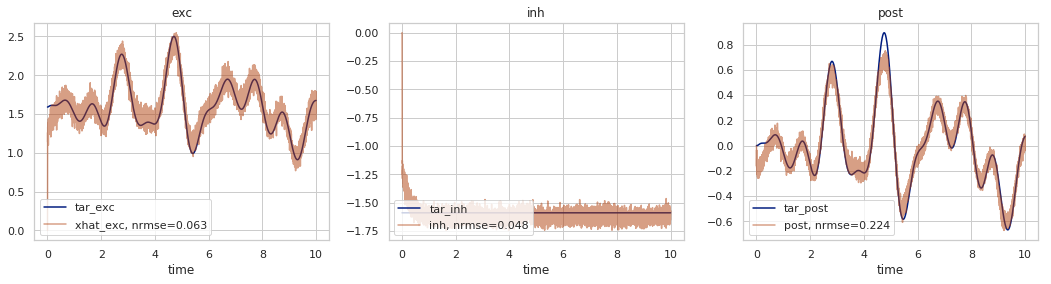

In [23]:
go()